# Insulin Control for Treating Type I Diabetes 

Luly Brea, Hannah Bruening, Daniel Tawil, Patrick Stepien  
Final Project for CBE 30338, Spring 2017

## Problem Statement

Type 1 Diabetes is a disease that affects the pancreas’ ability to regulate glucose levels within the body. In a healthy person, the pancreas acts as control system by using a combination of manipulated inputs. When blood sugar levels decrease, the pancreas receives a signal and subsequently releases the hormone “glucagon." Glucagon signals the liver to release glucose, which then increases sugar levels in the blood. When the blood sugar levels increase, the pancreas subsequently releases the hormone “insulin”, which causes the body tissue to store glucose thus decreasing blood sugar levels.

With Type 1 Diabetes, the body’s immune system attacks the insulin-producing beta cells in the pancreas, causing blood sugar levels to rise to dangerously high levels. Currently, Type 1 Diabetes is being treated by injecting insulin into the body. However, it is easy to overdose on insulin, causing the body to absorb too much glucose and allowing blood sugar levels to drop to a dangerous level. Symptoms of an insulin overdose include chills, confusion, shakiness, and even unconsciousness or even death.

## Technology Challenge

The traditional way to manage Type 1 diabetes is to manually check glucose levels throughout the day by using a hand-held meter. This meter takes a drop of the person’s blood and displays the glucose level on the monitor. The user would then calculate the amount of insulin they would have to inject based on their blood sugar levels. The American Diabetes Association recommends that the glucose concentration in blood should be 80 - 130 mg/dL before meals and less than 180 mg/dL 1 to 2 hours after meals. Typically, insulin shots are administered two to four times per day in order to regulate glucose levels. However, changes in diet and exercise can also affect glucose levels. 

Having to take insulin injections up to 4 times a day in addition to managing diet and exercise is a burden to those living with Type 1 Diabetes, and so other options for delivering insulin to patients have been developed and are continuously being improved. A more recently developed treatment option is an automated insulin pump, which automatically releases insulin into the body based on user input.

The objective of this project is to test different control methods that automate the entire treatment process. In order to achieve this objective, a device would need to be created that could take in the current blood glucose levels and adjust insulin output of the pump accordingly, essentially acting as an artificial pancreas. Using the glucose concentration guidelines outlined above, we plan on creating a control system that can regulate the blood sugar to healthy levels throughout the day using the control loop shown below.


![](Control Loop.jpg)

## Goals and Objectives

**1)** To create a simulation of a person with Type 1 Diabetes throughout the day with no treatment, in order to demonstrate the need for insulin treatment.

**2)** Apply the insulin pump and blood sugar sensor control loop and simulate the effect of this treatment. 

**3)** Find the PID constants that will optimize the insulin flow rate and keep the blood sugar at healthy levels (80 - 130 mg/dL before meals and less than 180 mg/dL 1 to 2 hours after meals). 

**4)** Establish a setpoint of 120 mg/dL and minimize deviation from the setpoint.

## Assumptions

**1)** Human Volume of Blood = 5 liters = .5 decaliters 

**2)** Volume of tissue affected by insulin (blood, muscle, liver) = 12 liters

**3)** Assume insulin sensitivity is constant such that one unit of insulin (1 mL) will remove 15 grams of carbohydrates from the blood, or 30,000 mg/dL.

**4)** The ideal range for blood glucose is between 80 and 130 mg/dL before meals and less than 180 mg/dL 1 to 2 hours after meals.

**5)** Assume the patient has access to sources of glucose or emergency glucagon if blood glucose levels fall dangerously low. 

**6)** Assume constant blood glucose level during the day and even use of glucose from the body. This means that food is the only disturbance variable for our system, and insulin is the only manipulated variable.


## Model Equations
The following equations were used to model glucose levels in the blood of a person with diabetes. $G$ ($\frac{mg}{dL}$) is defined as deviation in glucose concentration from the basal level. $I$ ($\frac{mU}{L}$) is defined as the deviation in blood insulin concentration from the basal level. $X$ ($\frac{mU}{L}$) is defined as the deviation in blood insulin concentration at the active site. $D(t)$, which is a function of time, is the disturbance variable in this model. $D$ ($\frac{mg}{dLmin}$) respresents the carbohydrates added to the blood when someone has a meal, thereby increasing the glucose concentration in a patient's blood. $U$, the manipulated variable, is the flow rate of insulin ($\frac{mU}{min}$). The control variable is total glucose concentration in the blood ($ G + G_{Basal}$).

$$ \frac{dG}{dt} = -p_1 G - X(G + G_{Basal}) + D$$

$$ \frac{dX}{dt} = -p_2 X + p_3 I $$

$$ \frac{dI}{dt} = -n(I + I_{Basal}) + \frac{U}{V_1}$$

# Preliminary Calculations

This first part of the simulation establishes the known constants for the model equations, defines the disturbance variable $D(t)$, and defines the model equations to be solved. The intial conditions were determined assuming steady state. Since the simulation begins with the diabetic patient waking up in the morning without having eaten since the night before, steady state is assumed since there will be no distrubance variable $D(t)$. Assuming steady state is a simplifictaion, since there are other bodily functions that could influence glucose levels, but the approximation is being made in order to estimate starting conditions for $G$, $I$, and $X$. 

In [12]:
%matplotlib inline
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

## Set Constants

In [13]:
#Constants from the source we used to attain our model equations 
p1 = 0.028735     # 1/min
p2 = 0.028344     # 1/min
p3 = 5.035E-5     # 1/min
n = .0926         # 1/min
V1 = 12           # Total Volume of Patient (L)
Ibasal = 15       # Baseline Blood Insulin Concentration (mU/L)
Gbasal = 81       # Baseline Blood Glucose Concentration (mg/dL)

# Set up time steps 
t = 0.0
t1 = 0.0
t2 = 0.0
t3 = 0.0
dt = 0.1
tf = 960.0

#Set Initial Conditions
G = 29             # Blood Glucose Concentration Deviation Variable (mg/dL)
X = -0.008         # Insulin Concentration at the active site (mU/L)
I = -4.3           # Blood Insulin Concentration Deviation Variable (mU/L)
U = 0.0            # Insulin Flow Rate (mU/min)

#Initialize arrays to store data for plotting
tlog= []
g1 = []
u = []
d = []
i = []

## Basic Simulation (No Treatment)

This simulation models the glucose level of a diabetic patient not receiving any type of insulin treatment, over the progression of  a day. The person is modeled as eating three meals, each 5 hours apart after an inital breakfast an hour after waking up.

In [14]:
# Initialize Basic Simulation
while (t<=tf):
    
    # If statement allows to introduce disturbance variables at different times throughout the day
    if t<=60:
        D = 0.0
    elif t<=360:
        D = 6.0*np.exp(-0.05*t1)    # Change leading coefficient to effect size of the meal (6.0 = small breakfast)
        t1 = t1+dt                  # Use new t to allow for reset of time for disturbance variable function
    elif t<=660: 
        D = 9.0*np.exp(-0.05*t2)    # (9.0 = medium lunch)
        t2 = t2+dt
    else:
        D = 12.0*np.exp(-0.05*t3)   # (12.0 = large dinner)
        t3 = t3+dt
        
    # Model Equations from Source     
    dGdt = -p1*G-X*(G+Gbasal)+D
    dG = dGdt*dt
    G = G + dG
    
    dXdt = -p2*X+p3*I
    dX = dXdt*dt
    X = X + dX
    
    dIdt = -n*(I+Ibasal)+U/V1
    dI = dIdt*dt
    I = I + dI
    
    # Update arrays for plotting
    u.extend([U])
    d.extend([D])
    i.extend([I+Ibasal])
    g1.extend([G+Gbasal])
    tlog.extend([t])
    
    # Move t forward to next time step
    t = t+dt    

## Plots for Patient with No Treatment

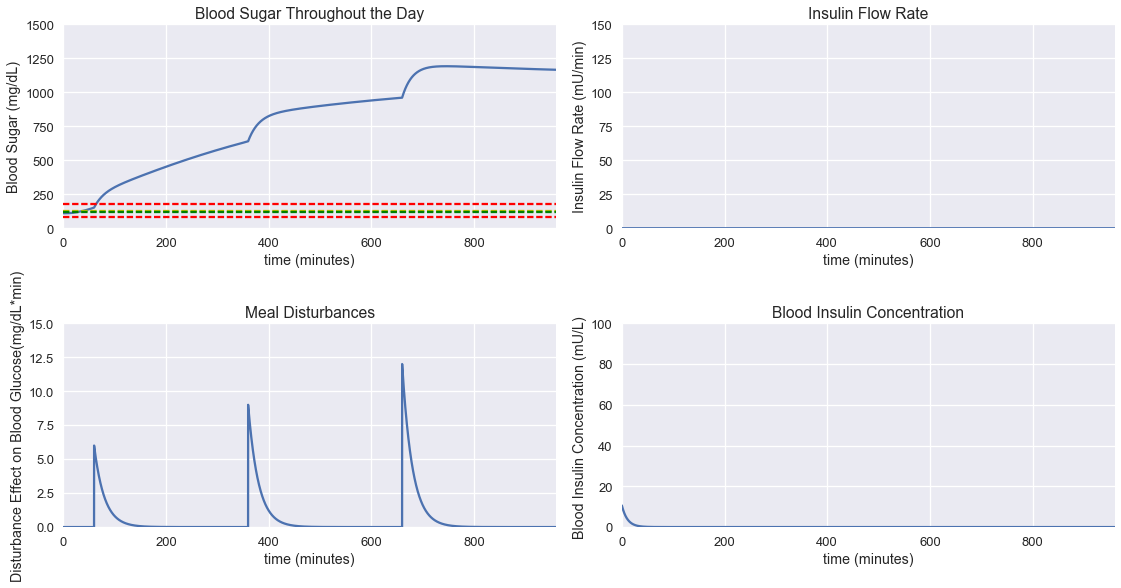

In [15]:
plt.figure(figsize=(16,16))

plt.subplot(4,2,1)
plt.plot(tlog,g1)
plt.axis([0,960,0,1500])
plt.plot([0,960],[80,80],'r--')
plt.plot([0,960],[130,130],'y--')
plt.plot([0,960],[180,180],'r--')
plt.plot([0,960],[120,120],'g--')
plt.title('Blood Sugar Throughout the Day')
plt.xlabel('time (minutes)')
plt.ylabel('Blood Sugar (mg/dL)')

plt.subplot(4,2,2)
plt.plot(tlog,u)
plt.tight_layout()
plt.axis([0,960,0,150])
plt.title('Insulin Flow Rate')
plt.xlabel('time (minutes)')
plt.ylabel('Insulin Flow Rate (mU/min)')

plt.subplot(4,2,3)
plt.plot(tlog,d)
plt.tight_layout()
plt.axis([0,960,0,15])
plt.title('Meal Disturbances')
plt.xlabel('time (minutes)')
plt.ylabel('Disturbance Effect on Blood Glucose(mg/dL*min)')

plt.subplot(4,2,4)
plt.plot(tlog,i)
plt.tight_layout()
plt.axis([0,960,0,100])
plt.title('Blood Insulin Concentration')
plt.xlabel('time (minutes)')
plt.ylabel('Blood Insulin Concentration (mU/L) ')

The top left plot depicts the diabetic patient's blood sugar levels throughout the day. The bottom left plot depicts the three disturbance peaks corresponding to the three meals eaten throughout the day. The first small peak simulates breakfast. The second medium peak simulates lunch. The third large peak simulates dinner. One can see steeper increases in total blood sugar (top left plot) correlating to the disturbance peaks in the plot below it for each meal.

## Plots of Insulin Treatment with Different U Values:
### Plotting deviation variables

In this part of the simulation, glucose concentration and insulin concentration deviation variables are being plotted versus time at different insulin flow rates, $U$, to determine a reasonable $U$ value to keep the glucose levels within the healthy range after a meal disturbance. 

In this code, the set point for G (deviation from basal glucose level) was set to $39$ $\frac{mg}{dL}$, because $G_{Basal} = 81$ $\frac{mg}{dL}$ and the goal is to achieve a total blood glucose concentration of $120$ $\frac{mg}{dL}$:
$$ G_{total} = G + G_{Basal} = 39 \frac{mg}{dL} + 81 \frac{mg}{dL} = 120 \frac{mg}{dL}$$


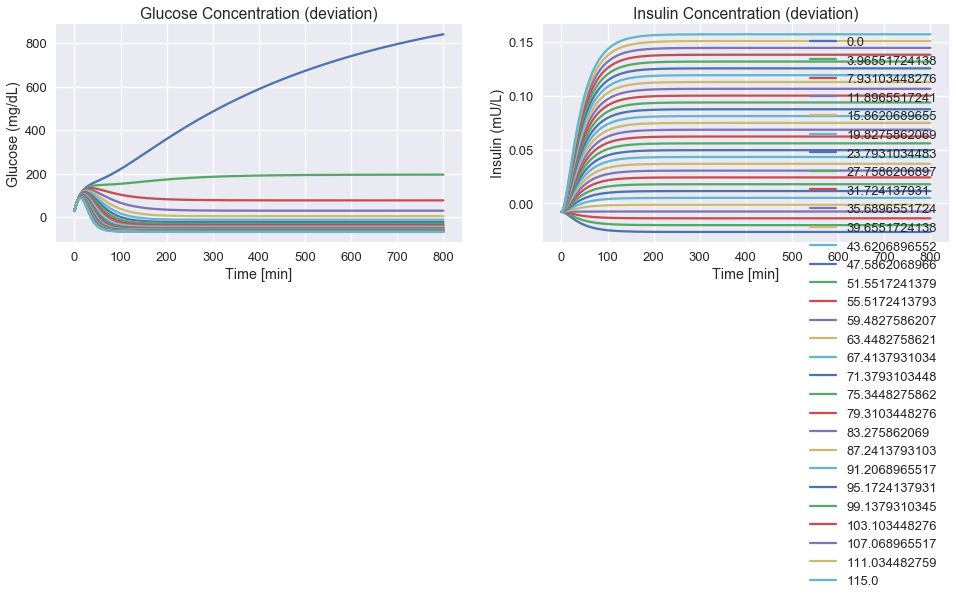

In [16]:
# Set Constants
p1 = 0.028735     # 1/min
p2 = 0.028344     # 1/min
p3 = 5.035E-5     # 1/min
n = .0926         # 1/min
V1 = 12           # L
Ibasal = 15       # mU/L
Gbasal = 81       # Kg/dL
U = 15            # nominal insulin flow rate - manipulated variable mU/min
tf = 800.0
t=0

# Set Initial Conditions
G0 = 29.3       # mg/dL
X0 = -0.008     # mU/L
I0 = -4.3       # mU/L

# disturbance: rate that glucose enters bloodstrem after meal
def D(t):
    return 9*np.exp(-0.05*t)

# model equations
def deriv(Z,t):
    G,X,I = Z   
    dG = -p1*G - X*(G + Gbasal) + D(t)
    dX= -p2*X + p3*I
    dI = -n*(I + Ibasal) + (U/V1)
    return [dG,dX,dI]

# visualization
def plotReactor(t,Z):
    plt.subplot(1,2,1)
    plt.plot(t,Z[:,0])
    plt.xlabel('Time [min]')
    plt.ylabel('Glucose (mg/dL)')
    plt.title('Glucose Concentration (deviation)')


    plt.subplot(1,2,2)
    plt.plot(t,Z[:,1])
    plt.xlabel('Time [min]')
    plt.ylabel('Insulin (mU/L)');
    plt.title('Insulin Concentration (deviation)')

# actual simulation
IC = [G0,X0,I0]                        # initial condition
t = np.linspace(0,800,2000)             # simulation time grid

qList = np.linspace(0,115,30)
        

plt.figure(figsize=(16,4))              # setup figure 
for U in qList:                        # for each insulin flow rate U
    Z = odeint(deriv,IC,t)              # perform simulation
    plotReactor(t,Z)                    # plot the results
    
plt.legend(qList)

In the two plots above, one can see the effect that different flow rates of insulin, $U$, ranging from $0$ $\frac{mU}{min}$ to $115$ $\frac{mU}{min}$ (the upper limit for the insulin flow rate that the designed pump can administer), have on glucose concentration and insulin concentration in the patient's blood. From the graph on the left of the glucose deviation variable, once can see that when $U = 0$, the glucose levels increase over this range of 800 min to extremely high levels, which would be very detrimental to the patient's health. On the other hand, one can see that at very high rates of U, glucose levels drop way too low, which would put the patient at risk of becoming hypoglycemic if they did not have any sources of glucagon nearby. (Note: Deviation variables are being plotted, or the deviation of glucose of insluin levels from basal levels, not total glucose or insulin levels. So the plotted G and I could be negative, meaning glucose or insulin levels dropped below their basal levels.) 

The simulation above is repeated below over a smaller range of $U$ values in order to better see what the optimal U value that would bring $G$ to the set point would be. 

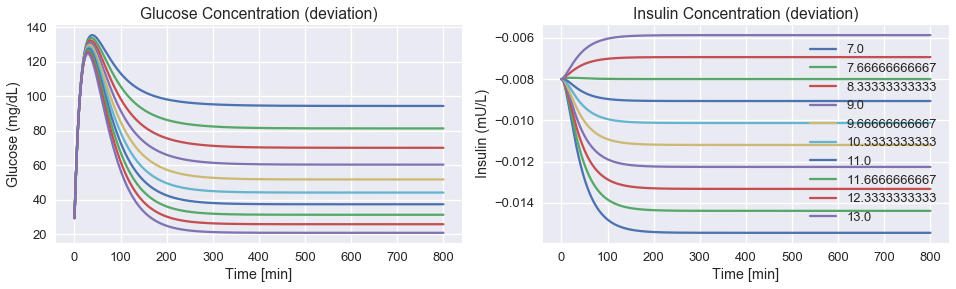

In [17]:
# actual simulation
IC = [G0,X0,I0]                        # initial condition
t = np.linspace(0,800,2000)             # simulation time 

qList = np.linspace(7,13,10)
        

plt.figure(figsize=(16,4))              # setup figure 
for U in qList:                        # for each flow rate U
    Z = odeint(deriv,IC,t)              # perform simulation
    plotReactor(t,Z)                    # plot the results
    
plt.legend(qList)

An initial $U$ value that would bring $G$ back down around the set point value was chosen based on the plots above. By looking at the $G$ plot, it was determined that a $U$ of about $11$ $\frac{mU}{min}$ would bring the glucose levels back within the safe range (bring the glucose deviation $G$ back to the set point).

Below is the simulation of a person with diabetes eating a meal (introducing a disturbance variable $D(t)$) and an insulin pump administering a constant insulin flow rate of $U = 11$ $\frac{mU}{min}$ (as determined from above). One can see, the glucose deviation variable spikes up because of the disturbance $D$, but is then brought back down by the amdinistered insulin. $G$ is brought close to the desired value of $39$ $\frac{mg}{dL}$. 

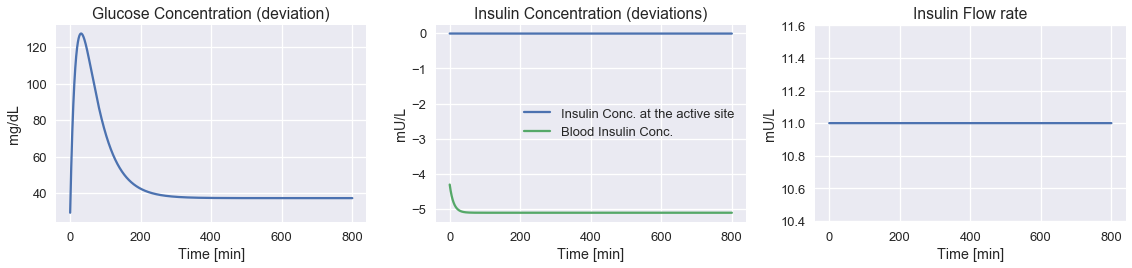

In [18]:
# set initial conditions 
IC = [G0,X0,I0]

# do simulation at fixed time steps dt
dt = 0.05
ti = 0.0
tf = 800

# create python list to log results
log = []

# start simulation
G,X,I = IC
U = 11.0
for t in np.linspace(ti,tf,int((tf-ti)/dt)+1):
    log.append([t,G,X,I,U])                      # log data for later plotting
    G,X,I = odeint(deriv,[G,X,I],[t,t+dt])[-1]   # start at t, find state at t + dt

def qplot(log):
    log = np.asarray(log).T
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.plot(log[0],log[1])
    plt.title('Glucose Concentration (deviation)')
    plt.ylabel('mg/dL')
    plt.xlabel('Time [min]')

    plt.subplot(1,3,2)
    plt.plot(log[0],log[2],log[0],log[3])
    if 'Tsp' in globals():
        plt.plot(plt.xlim(),[Tsp,Tsp],'r:')
    plt.title('Insulin Concentration (deviations)')
    plt.ylabel('mU/L')
    plt.xlabel('Time [min]')
    plt.legend(['Insulin Conc. at the active site','Blood Insulin Conc.'])

    plt.subplot(1,3,3)
    plt.plot(log[0],log[4])
    plt.title('Insulin Flow rate')
    plt.ylabel('mU/L')
    plt.xlabel('Time [min]')
    plt.tight_layout()

SS = log[-1]
qplot(log)

The $G$ plot above shows what effect adding a constant flow rate of U has on the glucose deviations. 

## Treatment Simulation with Constant Insulin Flow Rate:
### Plotting Total Glucose Level (not deviation variable)

This simulation models a diabetic patient eating three meals throughout a day (three disturbances) and receiving insulin treatment. This insulin treatment consists of a constant flow rate of insulin $U$ that does not change in response to the patient's glucose levels (no feedback control). The insulin flow rate $U = 11 \frac{mU}{min}$ used in this part of the simulation was determined using the plot of multiple $U$ values.

In [19]:
# Reset time steps 
t = 0.0
t1 = 0.0
t2 = 0.0
t3 = 0.0
dt = 0.1
tf = 960.0

# Reset Initial Conditions
G = 29             # Blood Glucose Concentration Deviation Variable (mg/dL)
X = -0.008         # Insulin Concentration at the active site Deviation Variable (mU/L)
I = -4.3           # Blood Insulin Concentration Deviation Variable (mU/L)
U = 11.0          # Insulin Flow Rate (mU/min), This is constant at the value later determined as ideal

# Reinitialize arrays 
tlog= []
g2 = []
u = []
d = []
i = []

# Run Simulation with Constant Insulin Flow Rate
while (t<=tf):
    
    # Meal Disturbance Simulation
    if t<=60:
        D = 0.0
    elif t<=360:
        D = 6.0*np.exp(-0.05*t1)
        t1 = t1+dt
    elif t<=660: 
        D = 9.0*np.exp(-0.05*t2)
        t2 = t2+dt
    else:
        D = 12.0*np.exp(-0.05*t3)
        t3 = t3+dt
        
    # Body Simulation     
    dGdt = -p1*G-X*(G+Gbasal)+D
    dG = dGdt*dt
    G = G + dG
    
    dXdt = -p2*X+p3*I
    dX = dXdt*dt
    X = X + dX
    
    dIdt = -n*(I+Ibasal)+U/V1
    dI = dIdt*dt
    I = I + dI
    
    # Store data in arrays for plotting
    u.extend([U])
    d.extend([D])
    i.extend([I+Ibasal])
    g2.extend([G+Gbasal])
    tlog.extend([t])
    
    # Move forward time step
    t = t+dt

## Plots for Patient Treated with Constant Insulin Flow Rate from Pump

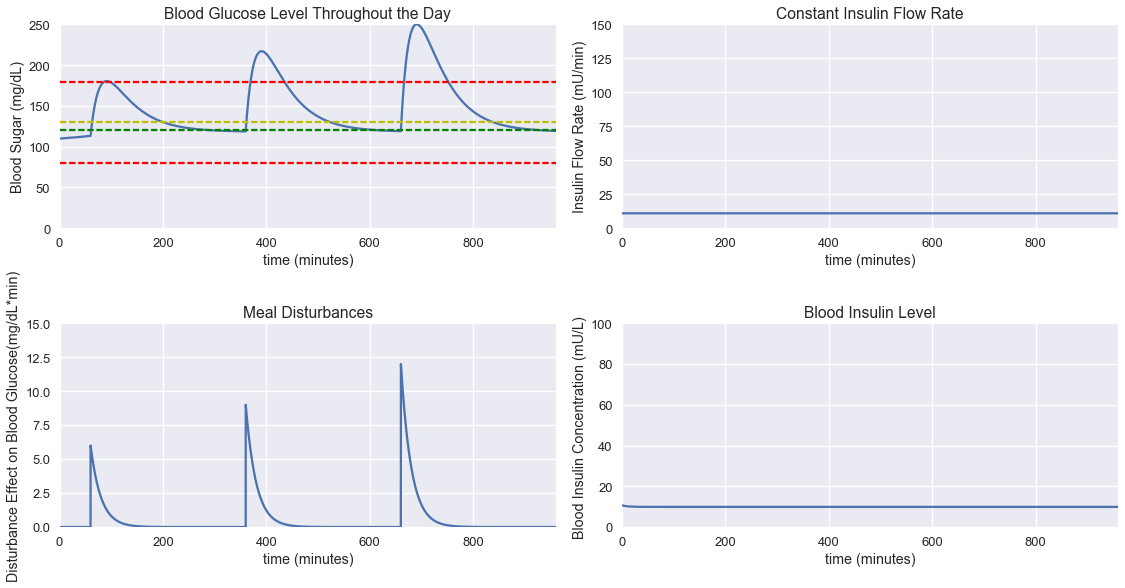

In [21]:
plt.figure(figsize=(16,16))

plt.subplot(4,2,1)
plt.plot(tlog,g2)
plt.axis([0,960,0,250])
plt.plot([0,960],[80,80],'r--')
plt.plot([0,960],[130,130],'y--')
plt.plot([0,960],[180,180],'r--')
plt.plot([0,960],[120,120],'g--')
plt.title('Blood Glucose Level Throughout the Day')
plt.xlabel('time (minutes)')
plt.ylabel('Blood Sugar (mg/dL)')

plt.subplot(4,2,2)
plt.plot(tlog,u)
plt.tight_layout()
plt.axis([0,960,0,150])
plt.title('Constant Insulin Flow Rate')
plt.xlabel('time (minutes)')
plt.ylabel('Insulin Flow Rate (mU/min)')

plt.subplot(4,2,3)
plt.plot(tlog,d)
plt.tight_layout()
plt.axis([0,960,0,15])
plt.title('Meal Disturbances')
plt.xlabel('time (minutes)')
plt.ylabel('Disturbance Effect on Blood Glucose(mg/dL*min)')

plt.subplot(4,2,4)
plt.plot(tlog,i)
plt.tight_layout()
plt.axis([0,960,0,100])
plt.title('Blood Insulin Level')
plt.xlabel('time (minutes)')
plt.ylabel('Blood Insulin Concentration (mU/L) ')

#The dashed lines on the blood glucose chart represent:
    # Red - 80 and 180 mg/dL which is the healthy blood sugar level range
    # Green - 120 mg/dL which represents the setpoint
    # Yellow - 130 mg/dL which is the blood sugar level a healhty person will be below 1-2 hours after a meal

As can be seen from the plot of the total glucose level in the patient's blood (top left), the constant flow rate of $U = 11 \frac{mU}{min}$ brings the glucose level to the setpoint of $G_{total} = 120 \frac{mg}{dL}$. However, the glucose level peaks out of the safe range for extended periods of time, which is not favorable. The peaks are also quite wide, meaning it is taking a long time for the glucose levels to drop back to the setpoint. Therefore, a PID controller will be designed to better respond to the patient's glucose levels and offer better treatment for people with diabetes. The PID controller will provide a quicker return to the setpoint (making the peaks narrower).

# PID Controller

With a PID controller and feedback control, the insulin pump can better respond to the patient's actual glucose levels. The glucose level is measured and the insulin flow rate to be administered $U$ is altered to respond to the person's elevated glucose level and bring that level back down to the setpoint.

The PID controller consists of a Proportional controller, Integral controller, and Derivative controller, according to the equation below. A PID controller offers the best control in terms of response time and stable response, which is why it was chosen for the insulin pump.

$$ U(t) = U_{Basal} + P(t) + I(t) + D(t)$$

### Proportional Control

$$ P(t) = K_p (G_m - G_{sp}) $$

If glucose is above the setpoint, then the proportional control will increase the amount of insulin released into the bloodstream based on the difference between the measured blood glucose level and the setpoint. If glucose is below the setpoint, then the proportional control will decrease the amount of insulin released into the bloodstream based on the difference between the measured blood glucose level and the setpoint. 

### Integral Control

$$ I(t) = \frac{K_p}{\tau_I} \int_0^t (G_m - G_{sp}) dt' $$

Integral control imitates basal insulin release by continuously releasing insulin, even when the glucose is at the setpoint. The integral control value responds to the difference between the measured blood glucose level and the setpoint. Integral control increases with increased proportional control in order to increase response time and decrease offset, and vice versa. 

### Derivative Control

$$ D(t) = K_p \tau_D \frac{d(G_m - G_{sp})}{dt} $$

Derivative control changes the amount of insulin released based on the change in the measured blood glucose level. If the rate of change is increasing, the pump will release more insulin, whereas if the rate of change is decreasing, the pump will release less insulin. This control function stabilizes the blood glucose level. 

### U(t) with PID control

Implementing PID control, the control equation for U(t) is:

$$ U(t) = U_{Basal} + K_P (G_m - G_{sp}) + K_I \int_0^t (G_m - G_{sp}) dt' + K_D \frac{d(G_m - G_{sp})}{dt}$$


$$K_I = \frac{K_P}{\tau_I}$$

$$K_D = K_P \tau_D$$

### Setpoint Weighting

$$ U(t) = U_{Basal} + K_P e_P(t) + K_I \int_0^t e_I(t') dt' + K_D \frac{e_D(t)}{dt}$$


$$ e_P(t) = G_m(t) - \beta G_{sp}(t)$$

$$ e_I(t) = G_m(t) -  G_{sp}(t)$$

$$ e_P(t) = G_m(t) - \gamma G_{sp}(t)$$

### Discrete Time Implementation


$$ U(t_k) = U_{Basal} + K_P e_P(t_k) + K_I dt \sum_o^{t_{k}} e_I (t_{k'}) + K_D \frac{e_D(t_k) - e_D (t_{k-1}) }{dt}$$

$$\Delta U(t_k) = U(t_k) - U(t_{k-1})$$

$$ U(t_k) = U_{Basal} + K_P (e_P(t_k)-e_P(t_{k-1})) + K_I dt e_I(t_k) + K_D \frac{e_D(t_k)-2e_D(t_{k-1})+e_D(t_{k-2})}{dt}$$

First, $G$ (the glucose deviation variable) is plotted versus time using PID control with a series of sliders in order to make the simulation interactive. Sliders were made for the $K_P$, $K_I$, and $K_D$ constants of the PID equations. These sliders can be used to determine optimal values for $K_P$, $K_I$, and $K_D$ for the PID controlled insulin treatment. The objective is to bring the glucose level back to the setpoint as quickly as possible, while minimizing overshoot. A greater emphasis is placed on minimizing overshoot because it is a more immediate danger to have low blood sugar levels than high. 

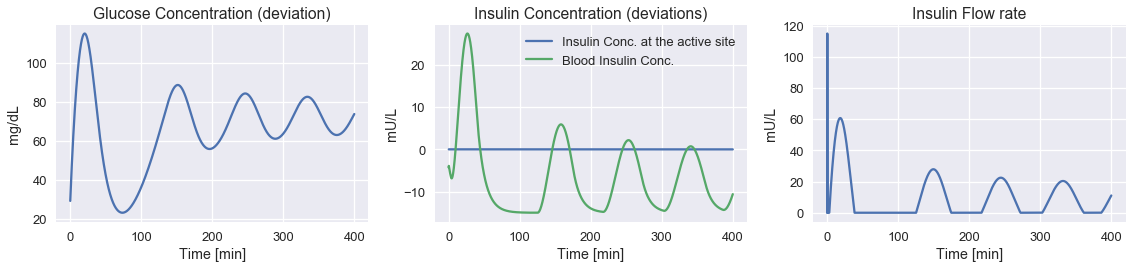

In [22]:
from ipywidgets import interact
# setpoint
Gsp = 39   #mg/dL

#disturbance: rate that glucose enters bloodstrem after meal
def D(t):
    return 9*np.exp(-0.05*t)

# model equations
def deriv(Z,t):
    G,X,I = Z   
    dG = -p1*G - X*(G + Gbasal) + D(t)
    dX= -p2*X + p3*I
    dI = -n*(I + Ibasal) + (U/V1)
    return [dG,dX,dI]

# set initial conditions 
IC = [G0,X0,I0]

# do simulation at fixed time steps dt
dt = 0.05
ti = 0.0
tf = 400


# set min and max values for U flowrate
U_min = 0                            # minimum possible insulin flow rate
U_max = 115                          # maximum possible insulin flow rate
def sat(U):                          # function to return feasible value of U
    return max(U_min,min(U_max,U))

def sim(Gsetpoint,kp,ki,kd):
    global Gsp, U
    Gsp = Gsetpoint
    
    # control parameters
    beta = 0
    gamma = 0

    # create python list to log results
    log = []

    # start simulation
    G,X,I = IC
    U =11.0
    Ubasal=11.0

    eP_ = G- beta*Gsp 
    eD_ = G- gamma*Gsp 
    eD__ = eD_

    for t in np.linspace(ti,tf,int((tf-ti)/dt)+1):
        # PID control calculations
        eP = G - beta*Gsp 
        eI = G - Gsp
        eD = G - gamma*Gsp 
        U = kp*(eP - eP_) + ki*dt*eI + kd*(eD - 2*eD_ + eD__)/dt + Ubasal
        U = sat(U)

        # log data and update state
        log.append([t,G,X,I,U])
        G,X,I = odeint(deriv,[G,X,I],[t,t+dt])[-1]     # start at t, find state at t + dt
    
        # save data for PID calculations
        eD__ = eD_
        eD_ = eD
        eP_ = eP

    qplot(log)
    
interact(sim,Gsetpoint = (0,150),kp = (0,100), ki=(0,50), kd=(0,100));

(Note: Due to using the same variable names throughout code, in order to interact with sliders you must run that segment of code right before trying to adjust.)

These interactive sliders above were used to optimize values for $K_P$, $K_I$, and $K_D$. After adjusting the sliders, it was determined that the optimal values for the PID controller would be $K_P = 96$, $K_I = 3$, and $K_D = 50$. These values bring the glucose level to the desired setpoint with little to no overshoot. 

Below, the PID control is implemented using the optimal $K_P$, $K_I$, and $K_D$ values found using the sliders in the simulation above. 

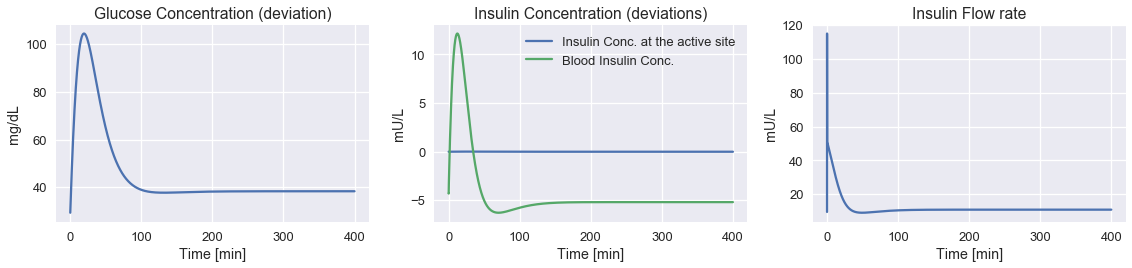

In [23]:
# setpoint
Gsp = 39   # mg/dL

# set initial conditions 
IC = [G0,X0,I0]

# do simulation at fixed time steps dt
dt = 0.05
ti = 0.0
tf = 400

# set min and max values for U flow rate
U_min = 0                            # minimum possible insulin flow rate
U_max = 115                          # maximum possible insulin flow rate
def sat(U):                          # function to return feasible value of U
    return max(U_min,min(U_max,U))

# control parameters
kp = 96
ki = 3
kd = 50
beta = 0
gamma = 0

# log results in python list
log = []

# start simulation
G,X,I = IC
U = 11.0
Ubasal= 11.0

eP_ = G- beta*Gsp 
eD_ = G- gamma*Gsp 
eD__ = eD_

for t in np.linspace(ti,tf,int((tf-ti)/dt)+1):
    # PID control calculations
    eP = G - beta*Gsp 
    eI = G - Gsp
    eD = G - gamma*Gsp 
    U = kp*(eP - eP_) + ki*dt*eI + kd*(eD - 2*eD_ + eD__)/dt +Ubasal
    U = sat(U)
    
    # log data and update state
    log.append([t,G,X,I,U])
    G,X,I = odeint(deriv,[G,X,I],[t,t+dt])[-1]     # start at t, find state at t + dt
    
    # save data for PID calculations
    eD__ = eD_
    eD_ = eD
    eP_ = eP

qplot(log)

One can see that using $K_P = 96$, $K_I = 3$, and $K_D = 50$ brings the glucose level back to the desired setpoint with minimal overshoot. 

## Insulin Treatment Simulation With PID Control

The simulation below models PID controlled insulin treatment of a diabetic patient eating three meals over the course of a day. The following glucose plot depicts total glucose levels in the patient's blood, not the deviation glucose variable. The optimal $K_P$, $K_I$, and $K_D$ values determined by the previous simulation are implemented into the simulation below.

In [24]:
# Reset time steps 
t = 0.0
t1 = 0.0
t2 = 0.0
t3 = 0.0
dt = 0.1
tf = 960.0

# Reset Initial Conditions
G = 29             # Blood Glucose Concentration Deviation Variable (mg/dL)
X = -0.008         # Insulin Concentration at the active site Deviation Variable (mU/L)
I = -4.3           # Blood Insulin Concentration Deviation Variable (mU/L)

# Reinitialize arrays 
tlog= []
g3 = []
u = []
d = []
i = []

# Set a baseline flow rate for the pump
Ubasal = 11.0

# Set the blood glucose concentration setpoint
Gsp = 120

# control saturation
U_min = 0.0                          # minimum possible insulin flow rate
U_max = 115                          # maximum possible insulin flow rate
def sat(U):                          # function to return feasible value of U
    return max(U_min,min(U_max,U))

# control parameters solved for using interactive tool above
kp = 96
ki = 3
kd = 50
beta = 0
gamma = 0

# Initial PID error calculations
eP_ = (G+Gbasal) - beta*Gsp
eD_ = (G+Gbasal) - gamma*Gsp
eD__ = eD_

while (t<=tf):
     
    # PID control calculations
    eP = (G+Gbasal) - beta*Gsp
    eI = (G+Gbasal) - Gsp
    eD = (G+Gbasal) - gamma*Gsp
    U = kp*(eP - eP_) + ki*dt*eI + kd*(eD - 2*eD_ + eD__)/dt +Ubasal
    U = sat(U)
    
    # Save data for PID calculations
    eD__ = eD_
    eD_ = eD
    eP_ = eP
    
    # Meal Disturbance Simulation
    if t<=60:
        D = 0.0
    elif t<=360:
        D = 6.0*np.exp(-0.05*t1)
        t1 = t1+dt
    elif t<=660: 
        D = 9.0*np.exp(-0.05*t2)
        t2 = t2+dt
    else:
        D = 12.0*np.exp(-0.05*t3)
        t3 = t3+dt
        
    # Body Simulation     
    dGdt = -p1*G-X*(G+Gbasal)+D
    dG = dGdt*dt
    G = G + dG
    
    dXdt = -p2*X+p3*I
    dX = dXdt*dt
    X = X + dX
    
    dIdt = -n*(I+Ibasal)+U/V1
    dI = dIdt*dt
    I = I + dI
    
    # Store data in arrays for plotting
    u.extend([U])
    d.extend([D])
    i.extend([I+Ibasal])
    g3.extend([G+Gbasal])
    tlog.extend([t])
    
    # Move forward time step
    t = t+dt

## Plots for Patient Treated with PID Controlled Insulin Pump

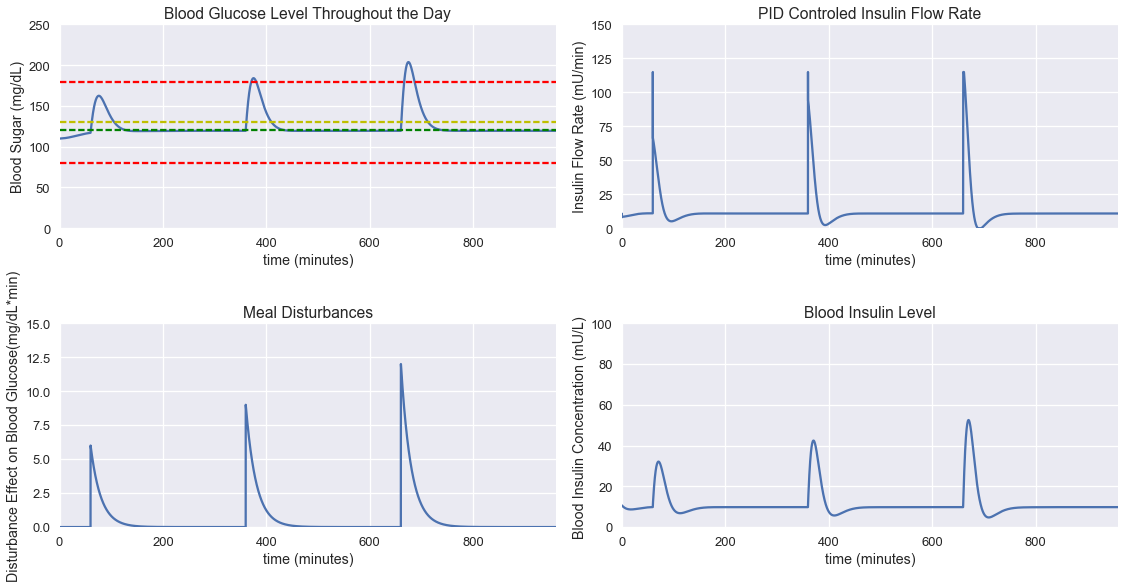

In [25]:
plt.figure(figsize=(16,16))

plt.subplot(4,2,1)
plt.plot(tlog,g3)
plt.axis([0,960,0,250])
plt.plot([0,960],[80,80],'r--')
plt.plot([0,960],[130,130],'y--')
plt.plot([0,960],[180,180],'r--')
plt.plot([0,960],[120,120],'g--')
plt.title('Blood Glucose Level Throughout the Day')
plt.xlabel('time (minutes)')
plt.ylabel('Blood Sugar (mg/dL)')

plt.subplot(4,2,2)
plt.plot(tlog,u)
plt.tight_layout()
plt.axis([0,960,0,150])
plt.title('PID Controled Insulin Flow Rate')
plt.xlabel('time (minutes)')
plt.ylabel('Insulin Flow Rate (mU/min)')


plt.subplot(4,2,3)
plt.plot(tlog,d)
plt.tight_layout()
plt.axis([0,960,0,15])
plt.title('Meal Disturbances')
plt.xlabel('time (minutes)')
plt.ylabel('Disturbance Effect on Blood Glucose(mg/dL*min)')

plt.subplot(4,2,4)
plt.plot(tlog,i)
plt.tight_layout()
plt.axis([0,960,0,100])
plt.title('Blood Insulin Level')
plt.xlabel('time (minutes)')
plt.ylabel('Blood Insulin Concentration (mU/L) ')


As can be seen in the plot of total glucose level on the top left, the glucose levels still peak fairly high, especially after the last two meals. So, a feedforward control is implemented in the simulation below to administer an additional $U_{Bolus}$ for each meal, in order to reduce the peak heights.

## Simulation with PID + Feedforward Control 

In order to implement feedforward control it is necessary to devise a way for the patient to communicate with the pump. The simulation below is modeled off a system where the patient hits one of three buttons on the pump, indicating whether they are about to eat a small, medium, or large meal. When the patient hits the button, the pump will administer a bolus of insulin corresponding to the amount of glucose the patient is about to consume. 


In order to optimize the insulin pump control, three factors had to be considered: 


**(1)** Over how much time should the insulin bolus be administered 

**(2)** How much insulin should be administered

**(3)** How long before the meal is eaten should the insulin bolus be injected


The simulation was run several times, varying the parameters in order to determine the optimal conditions for the feedforward control. It was determined that the feedforward control best met the objectives when the insulin bolus was administered all at once, 8 minutes before the meal was eaten. 


In [26]:
# Reset time steps 
t = 0.0
t1 = 0.0
t2 = 0.0
t3 = 0.0
dt = 0.1
tf = 960.0

# Reset Initial Conditions
G = 29             # Blood Glucose Concentration Deviation Variable (mg/dL)
X = -0.008         # Insulin Concentration at the active site Deviation Variable (mU/L)
I = -4.3           # Blood Insulin Concentration Deviation Variable (mU/L)

# Reinitialize arrays 
tlog= []
g4 = []
u = []
d = []
i = []

# Set a baseline flow rate for the pump
Ubasal = 11.0

# Set the blood glucose concentration setpoint
Gsp = 120

# control saturation
U_min = 0.0                          # minimum possible insulin flow rate
U_max = 115                          # maximum possible insulin flow rate
def sat(U):                          # function to return feasible value of U
    return max(U_min,min(U_max,U))

# control parameters solved for using interactive tool above
kp = 96
ki = 1
kd = 50
beta = 0
gamma = 0

# Initial PID error calculations
eP_ = (G+Gbasal) - beta*Gsp
eD_ = (G+Gbasal) - gamma*Gsp
eD__ = eD_

# Implement Three options for Feedforward control
smallbolus = 0
medbolus = 0
largebolus = 0

while (t<=tf):
     
    # PID control calculations
    eP = (G+Gbasal) - beta*Gsp
    eI = (G+Gbasal) - Gsp
    eD = (G+Gbasal) - gamma*Gsp
    U = kp*(eP - eP_) + ki*dt*eI + kd*(eD - 2*eD_ + eD__)/dt +Ubasal
    U = sat(U)
    
    # Save data for PID calculations
    eD__ = eD_
    eD_ = eD
    eP_ = eP
    
    # Meal Disturbance Simulation
    if t<=60:
        D = 0.0
    elif t<=360:
        D = 6.0*np.exp(-0.05*t1)
        t1 = t1+dt
    elif t<=660: 
        D = 9.0*np.exp(-0.05*t2)
        t2 = t2+dt
    else:
        D = 12.0*np.exp(-0.05*t3)
        t3 = t3+dt
    
    # Simulate Person Hitting "About to Eat Button" 2 minutes before they eat
    if t>=52 and t<=52.1: 
        smallbolus = 1
    elif t>=352 and t<=352.1:
        medbolus = 1
    elif t>=652 and t<=652.1:
        largebolus = 1
    else:
        smallbolus = 0 
        medbolus = 0
        largebolus = 0
        
    # When Bolus button is immediately pumps large amount of Insulin into Body depending on size of meal
    if smallbolus == 1:
        I = I + 20
        smallbolus = 0
    elif medbolus ==1:
        I = I + 60
        medbolus = 0
    elif largebolus == 1:
        I = I + 80
        largebolus = 0
    else:
        I = I
           
    # Body Simulation     
    dGdt = -p1*G-X*(G+Gbasal)+D
    dG = dGdt*dt
    G = G + dG
    
    dXdt = -p2*X+p3*I
    dX = dXdt*dt
    X = X + dX
    
    dIdt = -n*(I+Ibasal)+U/V1
    dI = dIdt*dt
    I = I + dI
    
    # Store data in arrays for plotting
    u.extend([U])
    d.extend([D])
    i.extend([I+Ibasal])
    g4.extend([G+Gbasal])
    tlog.extend([t])
    
    # Move forward time step
    t = t+dt

## Plots for Patient Treated with PID+Feedforward Controlled Insulin Pump

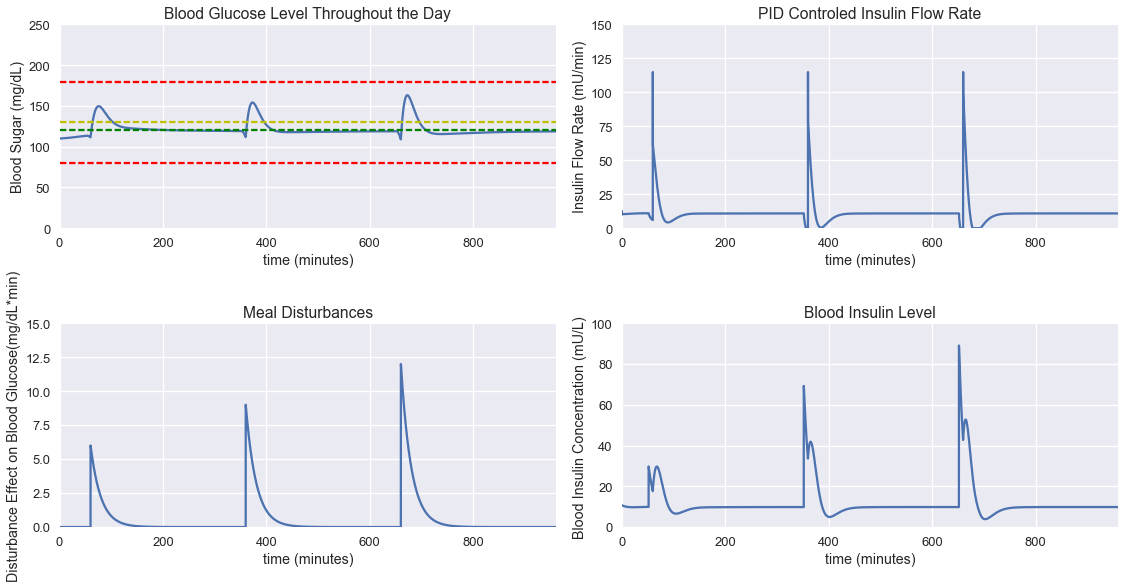

In [27]:
plt.figure(figsize=(16,16))

plt.subplot(4,2,1)
plt.plot(tlog,g4)
plt.axis([0,960,0,250])
plt.plot([0,960],[80,80],'r--')
plt.plot([0,960],[130,130],'y--')
plt.plot([0,960],[180,180],'r--')
plt.plot([0,960],[120,120],'g--')
plt.title('Blood Glucose Level Throughout the Day')
plt.xlabel('time (minutes)')
plt.ylabel('Blood Sugar (mg/dL)')

plt.subplot(4,2,2)
plt.plot(tlog,u)
plt.tight_layout()
plt.axis([0,960,0,150])
plt.title('PID Controled Insulin Flow Rate')
plt.xlabel('time (minutes)')
plt.ylabel('Insulin Flow Rate (mU/min)')


plt.subplot(4,2,3)
plt.plot(tlog,d)
plt.tight_layout()
plt.axis([0,960,0,15])
plt.title('Meal Disturbances')
plt.xlabel('time (minutes)')
plt.ylabel('Disturbance Effect on Blood Glucose(mg/dL*min)')

plt.subplot(4,2,4)
plt.plot(tlog,i)
plt.tight_layout()
plt.axis([0,960,0,100])
plt.title('Blood Insulin Level')
plt.xlabel('time (minutes)')
plt.ylabel('Blood Insulin Concentration (mU/L) ')

The glucose level plot above depicts the PID + feedforward control insulin treatment. One can see this treatement is better than the PID control alone, for the peaks stay well within the healthy glucose level range indicated by the dashed red lines. One can see the glucose peaks drop to the setpoint quickly, as well. $K_I$ was lowered to 1 in order to minimize additional offshoot which was introduced by the feedforward control. 

As can be seen in the bottom right plot of blood insulin level, the insulin bolus introduced by the feedforward control adds an additional spike in insulin to begin to reduce blood glucose levels before they deviate from the setpoint. This prevents the blood glucose level from peaking too high and returns glucose levels to the setpoint quickly.

## Results

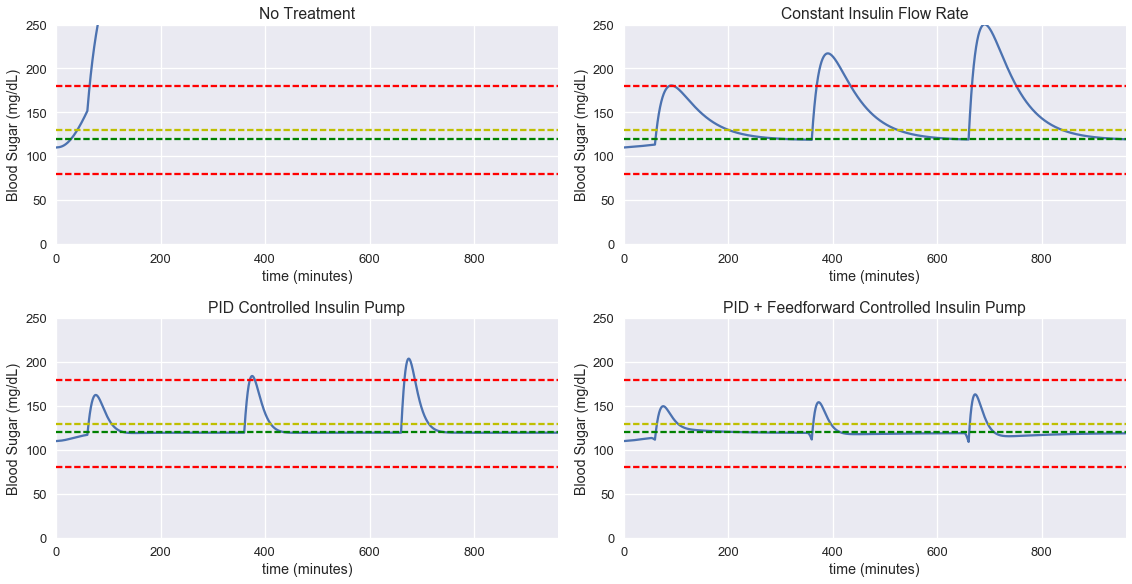

In [28]:
plt.figure(figsize=(16,16))

plt.subplot(4,2,1)
plt.plot(tlog,g1)
plt.axis([0,960,0,250])
plt.plot([0,960],[80,80],'r--')
plt.plot([0,960],[130,130],'y--')
plt.plot([0,960],[180,180],'r--')
plt.plot([0,960],[120,120],'g--')
plt.title('No Treatment')
plt.xlabel('time (minutes)')
plt.ylabel('Blood Sugar (mg/dL)')
plt.tight_layout()

plt.subplot(4,2,2)
plt.plot(tlog,g2)
plt.axis([0,960,0,250])
plt.plot([0,960],[80,80],'r--')
plt.plot([0,960],[130,130],'y--')
plt.plot([0,960],[180,180],'r--')
plt.plot([0,960],[120,120],'g--')
plt.title('Constant Insulin Flow Rate')
plt.xlabel('time (minutes)')
plt.ylabel('Blood Sugar (mg/dL)')
plt.tight_layout()

plt.subplot(4,2,3)
plt.plot(tlog,g3)
plt.axis([0,960,0,250])
plt.plot([0,960],[80,80],'r--')
plt.plot([0,960],[130,130],'y--')
plt.plot([0,960],[180,180],'r--')
plt.plot([0,960],[120,120],'g--')
plt.title('PID Controlled Insulin Pump')
plt.xlabel('time (minutes)')
plt.ylabel('Blood Sugar (mg/dL)')
plt.tight_layout()

plt.subplot(4,2,4)
plt.plot(tlog,g4)
plt.axis([0,960,0,250])
plt.plot([0,960],[80,80],'r--')
plt.plot([0,960],[130,130],'y--')
plt.plot([0,960],[180,180],'r--')
plt.plot([0,960],[120,120],'g--')
plt.title('PID + Feedforward Controlled Insulin Pump')
plt.xlabel('time (minutes)')
plt.ylabel('Blood Sugar (mg/dL)')
plt.tight_layout()

## Conclusions and Summary

  In conclusion, all objectives were achieved, as can be seen in the results section above. The “No Treatment” plot demonstrates a Type 1 diabetic patient who has had no insulin treatment, therefore achieving the first objective. As shown in the plot, blood sugar levels increase to dangerous levels without insulin treatment. 
   
  The insulin pump and blood glucose sensor feedback loop, in combination with a feedforward loop, provides appropriate insulin treatment for Type I diabetes. These two loops, which meet the second objective, are shown in the “PID and Feedforward Controlled Insulin Pump” plot in the results section. 
   
  When the PID controller is used alone, as shown in the “PID Controlled Insulin Pump” plot, the insulin treatment is capable of bringing blood glucose levels back down to the set point, which achieves the fourth objective. However, just using the PID controller causes the blood glucose levels to spike above the healthy range, which would fail the third objective. Adding the feedforward function improves upon the PID control system by decreasing the amount of time that the blood glucose level deviates from the set point, and keeping the blood glucose levels within the healthy range. Thus, using both the PID controller and the feed-forward system, as shown in the “PID and Feedforward Controlled Insulin Pump”, achieves the second, third, and fourth objectives.  



## References

http://www.jdrf.org/about/fact-sheets/type-1-diabetes-facts/ 

http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=1024561

http://www.healthline.com/health/diabetes/insulin-overdose#ODsymptoms4

http://www.diabetes.org/living-with-diabetes/treatment-and-care/blood-glucose-control/checking-your-bloodglucose.html?referrer=https://www.google.com/ 

http://www.livescience.com/32213-how-much-blood-is-in-the-human-body.html 

https://dtc.ucsf.edu/types-of-diabetes/type1/treatment-of-type-1-diabetes/medications-and-therapies/type-1-insulin-therapy/calculating-insulin-dose/ 

http://www.stat.yale.edu/~jtc5/diabetes/FeasibilityGarrySteil2006.pdf

Steil, Garry M., Kerstin Rebrin, Christine Darwin, Farzam Hariri, and Mohammed F. Saad. "Feasibility of Automating Insulin Delivery for the Treatment of Type 1 Diabetes." American Diabetes Association 55 (2006): 3344-350. Print. 
